In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import numpy as np

In [2]:
torch.manual_seed(42)

-----

In [3]:
#load the embedding matrix
import joblib
# embedding_dict = joblib.load('embeds.pkl')

word2idx = joblib.load('word_to_ids.pkl')
id_to_word = joblib.load('idx_to_word.pkl')

In [4]:
embed_dim = 300
print("Loading Word2Vec model ...")
import gensim.downloader as api

word2vec_model = api.load("word2vec-google-news-300")  # embed_dim will be 300

# Build the embedding matrix.
# For each word in our vocabulary, use the pre-trained embedding if available,
# otherwise initialize randomly.
vocab = list(word2idx.keys())
vocab_size = len(word2idx)
embedding_matrix = np.zeros((vocab_size, embed_dim), dtype=np.float32)

for word, idx in word2idx.items():
    if word in word2vec_model:
        embedding_matrix[idx] = word2vec_model[word]
    else:
        # For PAD token or out-of-vocabulary words, you might set to zeros or random values.
        # Here, we set PAD to zeros and random for others.
        if word == "<pad>":
            embedding_matrix[idx] = np.zeros(embed_dim, dtype=np.float32)
        else:
            embedding_matrix[idx] = np.zeros(embed_dim, dtype=np.float32)
# Convert the numpy matrix to a torch tensor.
embeddings_tensor = torch.tensor(embedding_matrix)

Loading Word2Vec model ...


In [5]:
embeddings_tensor.shape

torch.Size([607348, 300])

In [6]:
class DocTower(nn.Module):
    def __init__(self, embed_dim, lstm_hidden_dim, output_dim):
        """
        """
        super(DocTower, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings_tensor, padding_idx=0, freeze=True)
        self.lstm = nn.LSTM(embed_dim, lstm_hidden_dim, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)
    
    def forward(self, x, sequence_lengths):
        x = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            x,
            sequence_lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )
        _, (hn, _) = self.lstm(packed)
        last_hidden = hn[-1]  # Shape: (batch_size, lstm_hidden_dim)
        return self.fc(last_hidden)


In [7]:
class TwoTowerModel(nn.Module):
    def __init__(self, output_dim, embed_dim, lstm_hidden_dim_query, lstm_hidden_dim_doc):
        super(TwoTowerModel, self).__init__()
        self.query_tower = DocTower(embed_dim, lstm_hidden_dim_query, output_dim)
        self.doc_tower = DocTower(embed_dim, lstm_hidden_dim_doc, output_dim)
        
    def forward(self, query, doc_positive, doc_negative, query_length, doc_length):
        """
        :param query: Tensor of shape (batch_size, query_input_dim)
        :param positive_context: Tensor of shape (batch_size, seq_length) containing token indices
        :param candidate: Tensor of shape (batch_size, query_input_dim) for negative samples
        """
        query_embed = self.query_tower(query, query_length)
        positive_embed = self.doc_tower(doc_positive, doc_length)
        negative_embed = self.doc_tower(doc_negative, doc_length)
        return query_embed, positive_embed, negative_embed


In [8]:
#prepare the data for the query tower work on the query triplets
import json
with open('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/data/train_triples_sample.json') as f:
    data = json.load(f)

with open('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/eda/train_triples_v1.1.json') as f:
    train = json.load(f)

with open('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/eda/valid_triples_v1.1.json') as f:
    val = json.load(f)

In [9]:
average_sentence_length = sum(len(item['query'].split()) for item in data) / len(data)
print(average_sentence_length)#this before stemming and removing stopwords
average_context_length = sum(len(item['positive'].split()) for item in data) / len(data)
print(average_context_length)#this before stemming and removing stopwords

12.0
42.8


In [13]:
from tqdm import tqdm
from utils import tokenize
import pandas as pd

In [14]:
# df_val = pd.DataFrame(val)
# df_train = pd.DataFrame(train)
# df_tot = pd.concat([df_val, df_train])
# queries = df_tot['query'].unique()
# train_q, val_q = train_test_split(queries, test_size=0.2, random_state=42)

# train = df_tot[df_tot['query'].isin(train_q)]
# val = df_tot[df_tot['query'].isin(val_q)]

# train = train[['query', 'positive', 'negative']]
# val = val[['query', 'positive', 'negative']]
# train = train.to_dict('records')
# val = val.to_dict('records')

In [15]:
print(len(train), len(val))

676193 82360


In [16]:
#data preparartion

In [18]:
SENT_LEN = 12
CONTEXT_LEN = 40
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

def pad_truncate(data, max_len):
    res = []
    for d in tqdm(data):
        d = d.lower()
        d = re.sub(r'[^a-zA-Z0-9]', ' ', d)
        clean_sent = word_tokenize(d)
        tokens = clean_sent[:max_len]
        tokens += ['<unk>'] * (max_len - len(tokens))
        res.append(tokens)
    return res


In [77]:
# padded_query = pad_truncate(data, 'query', SENT_LEN)
# padded_positive = pad_truncate(data, 'positive', CONTEXT_LEN)
# padded_negative = pad_truncate(data, 'negative', CONTEXT_LEN)

In [19]:
#convert to indices using the word_to_id dictionary
# import joblib
# word_to_id = joblib.load('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/eda/word_to_ids.pkl')

In [20]:
#convert to indices
def convert_to_indices(data, word_to_id):
    res = []
    for d in tqdm(data):
        res.append([word_to_id.get(w, word_to_id['<unk>']) for w in d])
    return res

In [47]:
# padded_query = convert_to_indices(padded_query, word_to_id)
# padded_positive = convert_to_indices(padded_positive, word_to_id)
# padded_negative = convert_to_indices(padded_negative, word_to_id)

In [21]:
batch_size = 64

In [48]:
#Wrap in dataset and dataloader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

class QueryDataset(Dataset):
    def __init__(self, data, SENT_LEN, CONTEXT_LEN):
        self.queries = [d['query'] for d in data]
        self.positives = [d['positive'] for d in data]
        self.negatives = [d['negative'] for d in data]
        #pad truncates the data
        self.queries = pad_truncate(self.queries, SENT_LEN)
        self.positives = pad_truncate(self.positives, CONTEXT_LEN)
        self.negatives = pad_truncate(self.negatives, CONTEXT_LEN)
        #convert to indices
        self.queries = convert_to_indices(self.queries, word2idx)
        self.positives = convert_to_indices(self.positives, word2idx)
        self.negatives = convert_to_indices(self.negatives, word2idx)
    
    def __len__(self):
        return len(self.queries)
    
    def __getitem__(self, idx):
        return torch.tensor(self.queries[idx], dtype=torch.long), \
                torch.tensor(self.positives[idx], dtype=torch.long), \
                torch.tensor(self.negatives[idx], dtype=torch.long)
    
    def collate_fn(batch):
        queries, positives, negatives = zip(*batch)
        queries = torch.stack(queries)
        positives = torch.stack(positives)
        negatives = torch.stack(negatives)
        queries_lengths = torch.tensor([len(seq) for seq in queries], dtype=torch.int64)
        positives_lengths = torch.tensor([len(seq) for seq in positives], dtype=torch.int64)
        return queries, positives, negatives, queries_lengths, positives_lengths
    
train = train[:100000]
train, val = train_test_split(train, test_size=0.2, random_state=42)
# Wrap in dataset and dataloader
train_dataset = QueryDataset(train, SENT_LEN, CONTEXT_LEN)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=QueryDataset.collate_fn)

val_dataset = QueryDataset(val, SENT_LEN, CONTEXT_LEN)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=QueryDataset.collate_fn)

100%|██████████| 1600/1600 [00:00<00:00, 194462.08it/s]


In [49]:
for i in train_loader:
    keep_one = i
    print(i)
    print(i[0].shape)
    print(i[1].shape)
    break

(tensor([[584416, 138096, 151634, 531280, 559331, 105408, 498550, 329087,      0,
              0,      0,      0],
        [584416, 295896, 567081, 105408, 534510,      0,      0,      0,      0,
              0,      0,      0],
        [584416, 138096, 390707, 407923, 280157,      0,      0,      0,      0,
              0,      0,      0],
        [104171, 563695, 528950, 441807, 238620,      0,      0,      0,      0,
              0,      0,      0],
        [584416, 295896, 186045, 272768,      0,      0,      0,      0,      0,
              0,      0,      0],
        [450378, 271386, 381299, 403378, 296824,      0,      0,      0,      0,
              0,      0,      0],
        [180159, 273006, 138096, 242789, 519228, 274705, 192628, 274705, 179820,
          88681, 581832, 187190],
        [584416, 295896, 528950, 123020, 455662, 533029,      0,      0,      0,
              0,      0,      0],
        [438360, 410419, 124493, 381299, 105408, 528950, 584813, 360921, 450378

In [50]:
idx_to_word = joblib.load('/Users/yuliagoryachev/Documents/mlx/mlx_week2/two-tower-search/eda/idx_to_word.pkl')

print('The query')
print('========')
for i in keep_one[0][0]:
    #convert i from tensor to index
    print(idx_to_word[i.item()])
print('The positive')
print('========')
for i in keep_one[1][0]:
    #convert i from tensor to index
    print(idx_to_word[i.item()])

The query
what
does
general
agent
mean
in
bail
surety
<unk>
<unk>
<unk>
<unk>
The positive
general
agents
because
so
much
is
at
stake
in
backing
a
bail
bond
it
isn
t
easy
for
a
new
bail
agent
to
obtain
the
support
of
a
surety
company
until
a
bail
agent
acquires
the
experience
necessary
to
establish


In [82]:
# # Hyperparameters (example values)
# query_sequence_length = SENT_LEN
# doc_sequence_length = CONTEXT_LEN
# output_dim = 128
# embed_dim = 300
# lstm_hidden_dim = 64
# batch_size = 64

# # Instantiate the model
# model = TwoTowerModel(query_sequence_length, doc_sequence_length, output_dim, embed_dim, lstm_hidden_dim)


# # Define triplet loss
# triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

# class TripletLoss(nn.Module):
#     def __init__(self, margin=1.0):
#         super(TripletLoss, self).__init__()
#         self.margin = margin

#     def forward(self, query, pos_doc, neg_doc):
#         # Normalize embeddings to compute cosine similarity
#         query_norm = query / query.norm(dim=1, keepdim=True)
#         pos_doc_norm = pos_doc / pos_doc.norm(dim=1, keepdim=True)
#         neg_doc_norm = neg_doc / neg_doc.norm(dim=1, keepdim=True)
        
#         # Compute cosine similarities
#         pos_sim = torch.sum(query_norm * pos_doc_norm, dim=1) 
#         neg_sim = torch.sum(query_norm * neg_doc_norm, dim=1)
        
#         # Compute triplet loss
#         loss = torch.max(neg_sim - pos_sim + self.margin, torch.tensor(0)).mean()
#         return loss


# # Dummy inputs:
# # Query and candidate inputs (feature vectors)
# #random integers tensor
# query = torch.randint(0, 10, (batch_size, query_sequence_length))
# doc_positive = torch.randint(0, 20, (batch_size, doc_sequence_length))
# doc_negative = torch.randint(0, 20, (batch_size, doc_sequence_length))

# # Forward pass
# query_embed, positive_embed, candidate_embed = model(query, doc_positive, doc_negative)
# query_embed = query_embed.float()
# positive_embed = positive_embed.float()
# candidate_embed = candidate_embed.float()

# # Compute loss (assuming query is the anchor, positive_embed is the positive, and candidate_embed is the negative)
# # loss = triplet_loss_fn(query_embed, positive_embed, candidate_embed)
# margin = 1.0
# loss = TripletLoss(margin)(query_embed, positive_embed, candidate_embed)
# print(f"Triplet loss: {loss.item()}")

In [51]:
for i in val_loader:
    keep_one = i
    print(i)
    print(i[0].shape)
    print(i[1].shape)
    break

(tensor([[ 65966, 134559, 455662,  88681, 515983,      0,      0,      0,      0,
              0,      0,      0],
        [122700,  67162, 206010, 462577, 102699, 169701,      0,      0,      0,
              0,      0,      0],
        [584416,  52192, 295896, 142745, 356244, 105408,      0,      0,      0,
              0,      0,      0],
        [295896, 172503,  88681, 136077, 210662,      0,      0,      0,      0,
              0,      0,      0],
        [248615, 540045, 519228,      0,      0,      0,      0,      0,      0,
              0,      0,      0],
        [584416, 295896, 348581, 491541, 231708, 455662,      0,      0,      0,
              0,      0,      0],
        [456250, 393845, 528950, 134194, 342399, 563973, 372709,      0,      0,
              0,      0,      0],
        [104171, 295896,      0, 356244,      0,      0,      0,      0,      0,
              0,      0,      0],
        [584416, 295896,   4205, 559812,      0,      0,      0,      0,      0

In [52]:
# Hyperparameters (example values)
query_sequence_length = torch.tensor(SENT_LEN, dtype=torch.int64)
doc_sequence_length = torch.tensor(CONTEXT_LEN, dtype=torch.int64)
output_dim = 128
embed_dim = 300
lstm_hidden_dim_query = 128
lstm_hidden_dim_doc = 256
batch_size = 64

# Instantiate the model
model = TwoTowerModel(output_dim, embed_dim, lstm_hidden_dim_query, lstm_hidden_dim_doc)

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, query, pos_doc, neg_doc):
        pos_sim = F.cosine_similarity(query, pos_doc)
        neg_sim = F.cosine_similarity(query, neg_doc)
        
        # Compute triplet loss with margin
        loss = torch.clamp(self.margin - pos_sim + neg_sim, min=0.0)
        return loss.mean()

margin = 0.5
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#iterate over batches of the data
train_losses = []
valid_losses = []
epochs = 15
for epoch in range(epochs):
    model.train()
    new_lr = 0.001 * (0.95 ** epoch)  # example: exponentially decay the lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    for i, (query, positive, negative, query_lengths, doc_lengths) in enumerate(train_loader):
        query_embed, positive_embed, negative_embed = model(query, positive, negative, query_lengths, doc_lengths)
        query_embed = query_embed.float()
        positive_embed = positive_embed.float()
        negative_embed = negative_embed.float()
        optimizer.zero_grad()

        loss = TripletLoss(margin)(query_embed, positive_embed, negative_embed)
        loss.backward()

        # Backward pass
        optimizer.step()
        
        if i % 100 == 0:
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}")
    train_loss = loss.item()
    train_losses.append(train_loss)


    # Validation
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  
        for query, positive, negative, query_lengths, doc_lengths in val_loader:
            query_embed, positive_embed, negative_embed = model(query, positive, negative, query_lengths, doc_lengths)
            query_embed = query_embed.float()
            positive_embed = positive_embed.float()
            negative_embed = negative_embed.float()
            loss = TripletLoss(margin)(query_embed, positive_embed, negative_embed)
    valid_loss = loss.item()
    valid_losses.append(valid_loss)
    print(f"====Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {valid_loss}====")

Epoch 1, Batch 1, Loss: 0.5012868642807007
====Epoch 1, Train Loss: 0.31553488969802856, Validation Loss: 0.4233461022377014====
Epoch 2, Batch 1, Loss: 0.3465052545070648
====Epoch 2, Train Loss: 0.315114825963974, Validation Loss: 0.3678610026836395====
Epoch 3, Batch 1, Loss: 0.25182202458381653
====Epoch 3, Train Loss: 0.30199864506721497, Validation Loss: 0.26933753490448====
Epoch 4, Batch 1, Loss: 0.2171560823917389
====Epoch 4, Train Loss: 0.1962386965751648, Validation Loss: 0.23434138298034668====
Epoch 5, Batch 1, Loss: 0.18288366496562958
====Epoch 5, Train Loss: 0.17667296528816223, Validation Loss: 0.2123178243637085====
Epoch 6, Batch 1, Loss: 0.10561711341142654
====Epoch 6, Train Loss: 0.12042853236198425, Validation Loss: 0.20443084836006165====
Epoch 7, Batch 1, Loss: 0.05849893391132355
====Epoch 7, Train Loss: 0.08820849657058716, Validation Loss: 0.19855305552482605====
Epoch 8, Batch 1, Loss: 0.06174715235829353
====Epoch 8, Train Loss: 0.1074645146727562, Valida

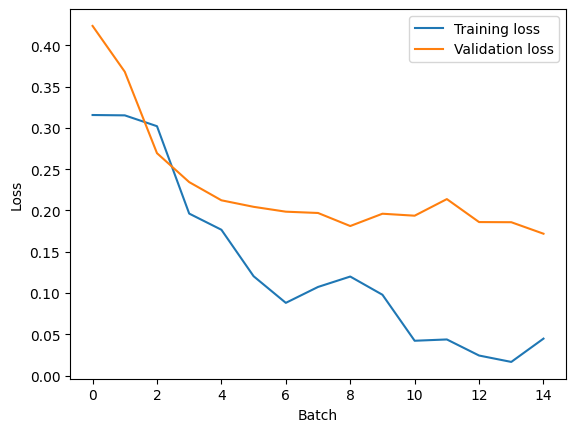

In [53]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

In [54]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

ind = 3
query = val[ind]['query']
print(query)
query_embed = torch.zeros(1, 300)
count_q = 0
for i in word_tokenize(query):
    print(i)
    token = word2idx.get(i, word2idx['<unk>'])
    print(token)
    query_embed+=embeddings_tensor[token]

query_embed = query_embed/max(count_q,1)

print('========')
#embed a positive context
positive_embed = torch.zeros(1, 300)
count_p = 0
positive = val[ind]['positive']
print(positive)
for i in word_tokenize(positive):
    print(i)
    token = word2idx.get(i, word2idx['<unk>'])
    positive_embed+=embeddings_tensor[token]
    print(token)

positive_embed = positive_embed/max(count_p,1)

print('========')
#embed a negative context
negative_embed = torch.zeros(1, 300)
count_p = 0
negative = val[ind]['negative']
print(negative)
for i in word_tokenize(negative):
    print(i)
    token = word2idx.get(i, word2idx['<unk>'])
    negative_embed+=embeddings_tensor[token]
    print(token)

negative_embed = negative_embed/max(count_p,1)

print(cosine_similarity(query_embed, positive_embed))
print(cosine_similarity(query_embed, negative_embed))

is starch a dietary fiber
is
295896
starch
172503
a
88681
dietary
136077
fiber
210662
Entering the dietary fiber mix is resistant starch, considered a third type of fiber that provides the benefits of both insoluble and soluble fibers. The term “resistant” refers to this starch’s ability to resist digestion.
Entering
369516
the
528950
dietary
136077
fiber
210662
mix
287868
is
295896
resistant
41916
starch
172503
,
72650
considered
379913
a
88681
third
555229
type
170020
of
455662
fiber
210662
that
124493
provides
247111
the
528950
benefits
50429
of
455662
both
600566
insoluble
439525
and
360921
soluble
407057
fibers
62837
.
593988
The
464955
term
553264
“
319706
resistant
41916
”
267451
refers
74134
to
274705
this
574964
starch
172503
’
331062
s
140903
ability
548787
to
274705
resist
552468
digestion
23111
.
593988
Parshin паршин. This patronymic surname is derived from Parsha, a diminutive form of the men's names Parfen, Paramon, Parmen. It is also suggested the name can derive from t

In [34]:
#clean punctuation

In [55]:
#check the result
count = 0
for query, positive, negative, query_lengths, doc_lengths in val_loader:
    query = query
    doc_pos = positive
    doc_neg = negative
    break

#cosine similarity before the model
query_embed, positive_embed, negative_embed = model(query, doc_pos, doc_neg, query_lengths, doc_lengths)
# cosine similarity after the model
print(F.cosine_similarity(query_embed, positive_embed))
print()
print(F.cosine_similarity(query_embed, negative_embed))

tensor([ 0.8831,  0.9118,  0.9265,  0.3961, -0.0615,  0.5458,  0.7517,  0.8453,
        -0.1983,  0.3212,  0.4095,  0.7004,  0.6447, -0.2888,  0.8504,  0.7431,
         0.6323,  0.5874,  0.6029,  0.7547, -0.5155,  0.6121,  0.0441,  0.7701,
        -0.0796,  0.7899,  0.7594,  0.7236,  0.7485,  0.5094,  0.7011,  0.8221,
         0.0946,  0.7722,  0.1047, -0.6811,  0.0991,  0.0396, -0.1769,  0.8463,
         0.5774,  0.5027,  0.2112,  0.1595,  0.4759, -0.1517,  0.7105, -0.1901,
         0.9369,  0.7461,  0.6600,  0.5083,  0.5047,  0.6546,  0.4328,  0.4339,
         0.5040,  0.8309,  0.7219,  0.6669,  0.4631,  0.7252,  0.8807,  0.9272],
       grad_fn=<SumBackward1>)

tensor([-0.0535,  0.6760,  0.6713, -0.5407, -0.1964, -0.1887, -0.5683,  0.0081,
        -0.5069, -0.1403, -0.5570, -0.8262, -0.5319, -0.9125,  0.5738, -0.5749,
        -0.1319,  0.8546,  0.1172,  0.8220, -0.4948, -0.3099,  0.1543, -0.6371,
         0.1690,  0.6101, -0.1244, -0.5557,  0.6883,  0.4418,  0.6820,  0.4418,
       

In [56]:
train[10]

{'query': 'equator location in ecuador',
 'positive': 'About Ecuador. Ecuador is situated along the north west coast of South America, and it borders the countries of Peru and Columbia. Ecuador’s capital is Quito which is less than 15 miles from the equator. The Galapagos Islands are considered a province of Ecuador.',
 'positive_url': 'http://www.ecuador.com/about/',
 'negative': 'Crude oil, commonly known as petroleum, is a liquid found within the Earth comprised of hydrocarbons, organic compounds and small amounts of metal. While hydrocarbons are usually the primary component of crude oil, their composition can vary from 50%-97% depending on the type of crude oil and how it is extracted. ',
 'negative_url': 'http://oilprice.com/Energy/Crude-Oil/What-Is-Crude-Oil-A-Detailed-Explanation-On-This-Essential-Fossil-Fuel.html'}

In [65]:
val[2]

{'query': 'what region is peru located in',
 'positive': 'Peru is one of twelve independent countries located in South America (not including French Guiana, which is an overseas region of France). The entire country is located south of the equator -- but only just. The equator runs through Ecuador to the north of Peru, missing Peru’s northernmost point by a small margin.',
 'positive_url': 'http://goperu.about.com/od/planningandpacking/ss/Where-Is-Peru-Located.htm',
 'negative': 'Remember, the accessory nerve, cranial nerve XI passes through the jugular foramen and also through the foramen magnum. It’s got two roots. You’ve got the roots up here and the spinal roots, which pass through the foramen magnum. The jugular foramen has loads of structures that pass through it. It’s called the ‘jugular foramen’ for a reason, because the internal jugular passes through it. I’ve just flipped back to the base of the skull view. You can see what I’m doing here, base of the skull',
 'negative_url':

In [66]:
#find the most similar search
query_text = val[2]['query']
documents_text = [i['positive'] for i in val[:64]]
print(query_text)
for t in documents_text:
    print(t)
query_text = [query_text]*64
#pad truncates the data
query = pad_truncate(query_text, SENT_LEN)
documents = pad_truncate(documents_text, CONTEXT_LEN)
#convert to indices
query = convert_to_indices(query, word2idx)
documents = convert_to_indices(documents, word2idx)

query = torch.tensor(query, dtype=torch.long)
documents = torch.tensor(documents, dtype=torch.long)

model.eval()  # Set model to evaluation mode
print(len(query), len(documents), query_lengths, doc_lengths)
with torch.no_grad():  
    query_embed, documents_embed, negative_embed = model(query, documents, documents, query_lengths, doc_lengths) 


# Compute cosine similarities
query_embed = query_embed[0].float().reshape(1,-1)
documents_embed = documents_embed.float()
cos = []
for em in documents_embed:
    cos.append(F.cosine_similarity(query_embed, em.reshape(1,-1)).item())


what region is peru located in
the median annual wage for veterinarians was $ 84460 in may 2012 the median wage is the wage at which half the workers in an occupation earned more than that amount and half earned less the lowest 10 percent earned less than $ 51530 and the top 10 percent earned more than $ 144100 
Probate and Family Court Fees. Note: The fees listed below do not include the fee for a citation or summons. Each citation is an additional $15 and each summons is an additional $5. Costs for publication, if applicable, are the responsibility of the petitioner/plaintiff
Peru is one of twelve independent countries located in South America (not including French Guiana, which is an overseas region of France). The entire country is located south of the equator -- but only just. The equator runs through Ecuador to the north of Peru, missing Peru’s northernmost point by a small margin.
Entering the dietary fiber mix is resistant starch, considered a third type of fiber that provides 

100%|██████████| 64/64 [00:00<00:00, 79583.59it/s]

64 64 tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12]) tensor([40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
        40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
        40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
        40, 40, 40, 40, 40, 40, 40, 40, 40, 40])


In [67]:
sorted_pairs = sorted(zip(cos, documents_text), key=lambda pair: pair[0], reverse=True)

# Extract sorted texts (lowest score first)
sorted_texts = [text for _, text in sorted_pairs]
for i in sorted_texts:
    print(i)
    print()

Peru is one of twelve independent countries located in South America (not including French Guiana, which is an overseas region of France). The entire country is located south of the equator -- but only just. The equator runs through Ecuador to the north of Peru, missing Peru’s northernmost point by a small margin.

4000-3000 B.C. The first copper water pipes were discovered by archaeologists in the Indus River Valley of India, dating back to 4000-3000 B.C. Just a few centuries later in 2500 B.C., Egyptians were credited with developing their own copper pipes to construct elaborate indoor bathrooms in pyramids. Most of us only think about plumbing when we are in need of a plumber—if a pipe bursts, a toilet backs up, or another plumbing emergency occurs. Beyond keeping pipes running smoothly with fresh, clean water for daily use, plumbing is a modern convenience that most of us take for granted.

Crude oil is pumped from the ground in the Middle East (e.g., Saudi Arabian Arab Light), Wes

In [68]:
#save the model
torch.save(model.state_dict(), './model_twotower.pth')

In [69]:
#load the model

# state_dict = torch.load('name.pth', map_location=torch.device('cpu'))
mmodel = torch.load('./model_twotower.pth', map_location='cpu')

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_79358/1414068615.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mmodel = torch.load('./model_twotower.pth', m

In [111]:
documents_text[np.argmax(cos)]

"Definition. Capillaries are the smallest type of blood vessel in the body. Their job is to enable the exchange of substances between the blood and surrounding tissues. One place where they can be easily seen (no pun intended!) from the outside is on the whites of the eyes. Capillaries are found in every square inch of the body, from the skin to the deepest tissues in the body's cavities. Capillaries are the thinnest blood vessels in the body. These vessels are found throughout the body and bring oxygen and necessary nutrients to every cell in the body and remove cell waste. Capillary walls are selectively permeable, allowing some, but not all substances through."

In [171]:
def average_pooling(data):
    embed = torch.zeros((1, 300))
    count = 0
    for id in data:
        if sum(embeddings_tensor[id])!=0:
            embed+=embeddings_tensor[id]
            count+=1
    # print(data,embed)
    return embed/max(count, 1)

In [177]:
#find the most similar search
query_text = val[2]['query']
documents_text = [i['positive'] for i in val[:64]]
print(query_text)
print()
# for t in documents_text:
#     print(t)
query_text = [query_text]*64
#pad truncates the data
query = pad_truncate(query_text, SENT_LEN)
print(query)
documents = pad_truncate(documents_text, CONTEXT_LEN)
#convert to indices
query = convert_to_indices(query, word2idx)
documents = convert_to_indices(documents, word2idx)
print(query)
query = torch.tensor(query, dtype=torch.long)
documents = torch.tensor(documents, dtype=torch.long)

model.eval()  # Set model to evaluation mode
print(len(query), len(documents), query_lengths, doc_lengths)
query_embed = [average_pooling(q) for q in query]
documents_embed = [average_pooling(q) for q in documents]

# Compute cosine similarities
query_embed = query_embed[0]
documents_embed = documents_embed
cos = []
for em in documents_embed:
    cos.append(F.cosine_similarity(query_embed, em.reshape(1,-1)).item())


shelf life for ground beef



100%|██████████| 64/64 [00:00<00:00, 37449.14it/s]


[['shelf', 'life', 'for', 'ground', 'beef', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['shelf', 'life', 'for', 'ground', 'beef', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['shelf', 'life', 'for', 'ground', 'beef', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['shelf', 'life', 'for', 'ground', 'beef', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['shelf', 'life', 'for', 'ground', 'beef', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['shelf', 'life', 'for', 'ground', 'beef', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['shelf', 'life', 'for', 'ground', 'beef', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['shelf', 'life', 'for', 'ground', 'beef', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['shelf', 'life', 'for', 'ground', 'beef', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], ['shelf', 'life', 'for', 'ground', '

100%|██████████| 64/64 [00:00<00:00, 19300.79it/s]

[[25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190, 80469, 483009, 0, 0, 0, 0, 0, 0, 0], [25775, 534311, 187190,

In [178]:
sorted_pairs = sorted(zip(cos, documents_text), key=lambda pair: pair[0], reverse=True)

# Extract sorted texts (lowest score first)
sorted_texts = [text for _, text in sorted_pairs]
for i in sorted_texts:
    print(i)
    print()

Fresh ground beef goes through a number of color changes during its shelf life. These color changes are normal, and the ground beef remains perfectly wholesome and safe to eat within 1-2 days of purchase. If ground beef is refrigerated promptly after cooking, it can be safely refrigerated for about 3 or 4 days. If frozen, it should keep its quality for about 4 months. When reheating fully cooked patties or casseroles containing ground beef, be sure the internal temperature reaches 165 F or it is hot and steaming.

Flip the steak and cook for an additional 1-2 minutes over high heat. You won't need as much time on the second side of the steak because it will continue to develop color (from contact with the bottom of the pan) in the oven. Place the steak gingerly inside the pan and lower the skillet's handle back down. 1  Adjust the steak with tongs to ensure that it's getting equal coverage on the pan (for a better crust), but don't press down on the steak with your tongs in an attempt 

In [54]:
#embed a query
query = "How to make a cake"
#pad and truncate
query = pad_truncate([query], 4)
query = convert_to_indices(query, word_to_id)

100%|██████████| 1/1 [00:00<00:00, 6955.73it/s]


In [55]:
import numpy as np
query = train[0]['query']
print(query)
query_embed = np.zeros((1, 300))
count_q = 0
for i in tokenize(query, punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True):
    print(i)
    token = word_to_id.get(i, word_to_id['<unk>'])
    query_embed+=embedding_dict.get(token, np.zeros(300))
    print(token)

query_embed = query_embed/max(count_q,1)

print('========')
#embed a positive context
positive_embed = np.zeros((1, 300))
count_p = 0
positive = train[0]['positive']
print(positive)
for i in tokenize(positive, punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True):
    print(i)
    token = word_to_id.get(i, word_to_id['<unk>'])
    positive_embed+=embedding_dict.get(token, np.zeros(300))
    print(token)

positive_embed = positive_embed/max(count_p,1)

print('========')
#embed a negative context
negative_embed = np.zeros((1, 300))
count_p = 0
negative = train[0]['negative']
print(negative)
for i in tokenize(negative, punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True):
    print(i)
    token = word_to_id.get(i, word_to_id['<unk>'])
    negative_embed+=embedding_dict.get(token, np.zeros(300))
    print(token)

negative_embed = negative_embed/max(count_p,1)

what is rba
rba
722428
Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.
sinc
401098
rba
722428
outstand
426933
reput
307411
affect
1188611
secur
734919
npa
740575
scandal
1018751
rba
722428
subsidiari
1036929
involv
70290
bribe
1027549
oversea
1098502
offici
888271
australia
187620
might
396564
win
276869
lucr
541905
note
287077
print
514386
contract
355724
asset
219015
bank
901419
includ
266098
gold
47891
foreign
572029
exchang
309358
reserv
1200897
australia
187620
estim
975472
net
1190646
worth
1157870
billion
1036595
nearli
21564
rba
722428
employ

In [56]:
#cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(query_embed, positive_embed))
print(cosine_similarity(query_embed, negative_embed))

[[0.47809076]]
[[0.08634104]]


In [67]:
(query_embed * positive_embed).sum()/np.linalg.norm(query_embed)/np.linalg.norm(positive_embed)

0.47809076495182673

In [30]:
from typing import List
import numpy as np

In [91]:

train, validation = train_test_split(train, test_size=0.3, random_state=42)

In [92]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
class QueryDataset(Dataset):
    def __init__(self, data):
        self.queries = [d['query'] for d in data]
        self.positives = [d['positive'] for d in data]
        self.negatives = [d['negative'] for d in data]
        print('tokenize')
        self.queries = [tokenize(i,punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True)  for i in tqdm(self.queries)]
        self.positives = [tokenize(i,punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True)  for i in tqdm(self.positives)]
        self.negatives = [tokenize(i,punctuation_map=punctuation_map, stemmer=PorterStemmer(), junk_punctuations=True)  for i in tqdm(self.negatives)]

        print('average pooling')
        self.queries = [self.average_pooling(i) for i in tqdm(self.queries)]
        self.positives = [self.average_pooling(i) for i in tqdm(self.positives)]
        self.negatives = [self.average_pooling(i) for i in tqdm(self.negatives)]
    
    def average_pooling(self, data: List[str]):
        embed = np.zeros((1, 300))
        count = 0
        for d in data:
            token = word_to_id.get(d, word_to_id['<unk>'])
            embed+=embedding_dict.get(token, np.zeros(300))
            count+=1
        # print(data,embed)
        return embed/max(count, 1)
    
    def __len__(self):
        return len(self.queries)
    
    def __getitem__(self, idx):
        return torch.tensor(self.queries[idx], dtype=torch.float32), \
                torch.tensor(self.positives[idx], dtype=torch.float32), \
                torch.tensor(self.negatives[idx], dtype=torch.float32)
    
    def collate_fn(batch):
        queries, positives, negatives = zip(*batch)
        queries = torch.stack(queries)
        positives = torch.stack(positives)
        negatives = torch.stack(negatives)
        return queries, positives, negatives
    

# Wrap in dataset and dataloader
train_dataset = QueryDataset(train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=QueryDataset.collate_fn)

val_dataset = QueryDataset(validation)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=QueryDataset.collate_fn)

tokenize


100%|██████████| 473335/473335 [02:22<00:00, 3327.79it/s]


average pooling
tokenize


100%|██████████| 202858/202858 [01:01<00:00, 3322.41it/s]


average pooling


In [93]:
len(train)

473335

In [94]:
# for i in train_dataset:
#     keep_one = i
#     print(i)
#     print(i[0].shape)
#     print(i[1].shape)
#     break

In [95]:
# import os
# import sys
# src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
# if src_path not in sys.path:
#     sys.path.insert(0, src_path)

In [96]:
class OneTower(nn.Module):
    def __init__(self, embed_dim, med_dim, output_dim):
        super(OneTower, self).__init__()
        self.fc = nn.Linear(embed_dim, med_dim)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(med_dim, output_dim)
    
    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.fc1(x)
        return x
    
class TwoTowerModel(nn.Module):
    def __init__(self, embed_dim, med_dim, output_dim):
        super(TwoTowerModel, self).__init__()
        self.query_tower = OneTower(embed_dim, med_dim, output_dim)
        self.doc_tower = OneTower(embed_dim, med_dim, output_dim)
        
    def forward(self, query, doc_positive, doc_negative):
        """
        :param query: Tensor of shape (batch_size, query_input_dim)
        :param positive_context: Tensor of shape (batch_size, seq_length) containing token indices
        :param candidate: Tensor of shape (batch_size, query_input_dim) for negative samples
        """
        query_embed = self.query_tower(query)
        positive_embed = self.doc_tower(doc_positive)
        negative_embed = self.doc_tower(doc_negative)
        return query_embed, positive_embed, negative_embed

In [98]:
# Hyperparameters (example values)
output_dim = 64
med_dim = 128
embed_dim = 300
batch_size = 32

# Instantiate the model
model = TwoTowerModel(embed_dim, med_dim,  output_dim)

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, query, pos_doc, neg_doc):
        pos_sim = F.cosine_similarity(query, pos_doc)
        neg_sim = F.cosine_similarity(query, neg_doc)
        
        # Compute triplet loss with margin
        loss = torch.clamp(self.margin - pos_sim + neg_sim, min=0.0)
        return loss.mean()

margin = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#iterate over batches of the data
train_losses = []
val_losses = []
epochs = 30
for epoch in range(epochs):
    model.train()
    for i, (query, positive, negative) in enumerate(val_loader):
        query_embed, positive_embed, negative_embed = model(query, positive, negative)
        query_embed = query_embed.float()
        positive_embed = positive_embed.float()
        negative_embed = negative_embed.float()
        optimizer.zero_grad()

        loss = TripletLoss(margin)(query_embed, positive_embed, negative_embed)
        loss.backward()

        # Backward pass
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = loss.item()
            
    # Validation
    model.eval()  # Set model to evaluation mode
    valid_loss = 0.0
    with torch.no_grad():  
        for query, positive, negative in val_loader:
            query_embed, positive_embed, negative_embed = model(query, positive, negative)
            query_embed = query_embed.float()
            positive_embed = positive_embed.float()
            negative_embed = negative_embed.float()
            loss = TripletLoss(margin)(query_embed, positive_embed, negative_embed)
            valid_loss += loss.item()
        valid_loss = loss.item()
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {valid_loss}")


Epoch 1, Train Loss: 0.10337500274181366, Validation Loss: 0.10026563704013824
Epoch 2, Train Loss: 0.09100000560283661, Validation Loss: 0.07540624588727951
Epoch 3, Train Loss: 0.0566718764603138, Validation Loss: 0.05353124812245369
Epoch 4, Train Loss: 0.05356249213218689, Validation Loss: 0.05976561829447746
Epoch 5, Train Loss: 0.07212499529123306, Validation Loss: 0.07835938036441803
Epoch 6, Train Loss: 0.07848437130451202, Validation Loss: 0.06293749809265137
Epoch 7, Train Loss: 0.04728124290704727, Validation Loss: 0.04729687049984932
Epoch 8, Train Loss: 0.06615625321865082, Validation Loss: 0.06612499803304672
Epoch 9, Train Loss: 0.044218745082616806, Validation Loss: 0.05043749883770943
Epoch 10, Train Loss: 0.059859372675418854, Validation Loss: 0.056734371930360794
Epoch 11, Train Loss: 0.056765615940093994, Validation Loss: 0.05053124576807022
Epoch 12, Train Loss: 0.028656240552663803, Validation Loss: 0.028656240552663803
Epoch 13, Train Loss: 0.0442812480032444, Va

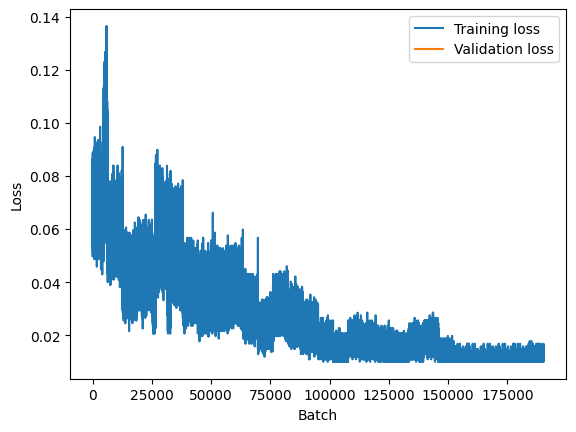

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])
plt.show()